In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

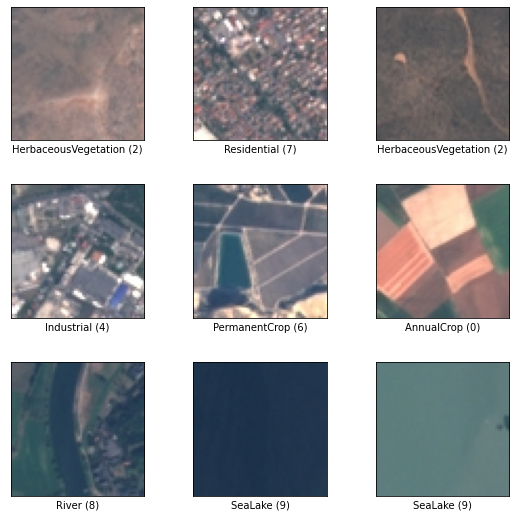

In [40]:
ds, ds_info  = tfds.load('eurosat/rgb', with_info=True, split='train')
figure = tfds.show_examples(ds, ds_info)

In [41]:
ds_info

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

In [42]:
(ds_train, ds_test), ds_info = tfds.load('eurosat/rgb',  with_info=True,
                                          split=['train[:80%]', 'train[80%:]'],
                                          shuffle_files=True, as_supervised=True)

In [43]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 70, 70) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[64, 64, 3]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  return image,label

ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(int(ds_info.splits['train'].num_examples * 0.8))
ds_train = ds_train.batch(16)

In [44]:
ds_test = ds_test.map(convert, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(16)
ds_test = ds_test.cache()

In [45]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10))

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_test, epochs=30, verbose=1)

Epoch 1/30
1350/1350 [==============================] - 17s 12ms/step - loss: 1.6713 - accuracy: 0.3535 - val_loss: 1.1912 - val_accuracy: 0.54898 -  - 1
Epoch 2/30
1350/1350 [==============================] - 7s 5ms/step - loss: 1.2589 - accuracy: 0.5223 - val_loss: 1.0213 - val_accuracy: 0.6087
Epoch 3/30
1350/1350 [==============================] - 7s 6ms/step - loss: 1.0760 - accuracy: 0.6097 - val_loss: 0.7649 - val_accuracy: 0.7198
Epoch 4/30
1350/1350 [==============================] - 7s 6ms/step - loss: 0.9274 - accuracy: 0.6738 - val_loss: 0.7020 - val_accuracy: 0.7511
Epoch 5/30
1350/1350 [==============================] - 7s 6ms/step - loss: 0.8525 - accuracy: 0.7025 - val_loss: 0.6521 - val_accuracy: 0.7744
Epoch 6/30
1350/1350 [==============================] - 7s 6ms/step - loss: 0.7655 - accuracy: 0.7353 - val_loss: 0.6436 - val_accuracy: 0.7763
Epoch 7/30
1350/1350 [==============================] - 7s 6ms/step - loss: 0.7192 - accuracy: 0.7525 - val_loss: 0.5839 - val

In [47]:
test_loss, test_acc = model.evaluate(ds_test, verbose=1)

    338/Unknown - 2s 6ms/step - loss: 0.7976 - accuracy: 0.8472

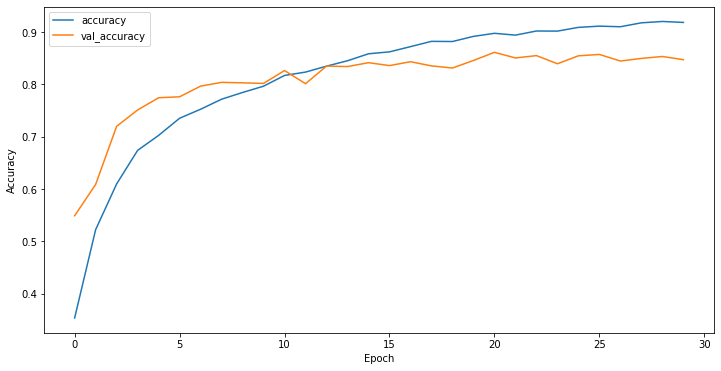

In [48]:
fig = plt.figure(figsize=(12,6))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

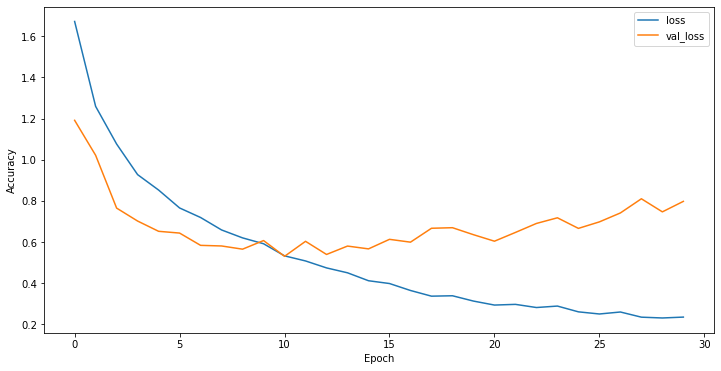

In [49]:
fig = plt.figure(figsize=(12,6))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()